In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from tqdm.auto import tqdm
from colorama import Fore, Style

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import sys
sys.path.append(".")
sys.path.append("scripts")
import rr_em

from berp.generators import thresholded_recognition_simple as generator
from berp.generators.response import simple_gaussian
from berp.generators.stimulus import Stimulus, RandomStimulusGenerator
from berp.models.reindexing_regression import ModelParameters, scatter_response_model
from berp.models.trf import TemporalReceptiveField, TRFDelayer

from berp.util import time_to_sample

## Generate synthetic data

In [4]:
# Establish parameters used to synthesize data
# Obviously these will not be used during inference!

coef_mean = torch.tensor([-1.])
params = ModelParameters(
    lambda_=pyro.deterministic("lambda", torch.tensor(1.0)),
    confusion=generator.phoneme_confusion,
    threshold=pyro.sample("threshold",
                          dist.Beta(1.2, 1.2)),

    # NB only used for generation, not in model
    a=pyro.deterministic("a", torch.tensor(0.2)),
    b=pyro.deterministic("b", torch.tensor(0.1)),
    coef=pyro.deterministic("coef", coef_mean),
    sigma=pyro.deterministic("sigma", torch.tensor(5.0)),
)

print(f"{Style.BRIGHT}Critical parameters:{Style.RESET_ALL}")
print("Threshold:\t", params.threshold.item())
print("Noise sigma:\t", params.sigma.item())

Critical parameters:
Threshold:	 0.32520657777786255
Noise sigma:	 5.0


In [57]:
epoch_window = (0.0, 0.55)
stim = RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=params.confusion.shape[0],
                               word_surprisal_params=(2.0, 0.5))
ds_args = dict(response_type="gaussian", epoch_window=epoch_window, include_intercept=False, sample_rate=48)
dataset = generator.sample_dataset(params, stim, **ds_args)
test_dataset = generator.sample_dataset(params, stim, **ds_args)

### Visualize characteristic response

This is the shape of the word recognition response used in the data that we wish to infer:

Text(0.5, 1.0, 'Characteristic response in synthetic dataset')

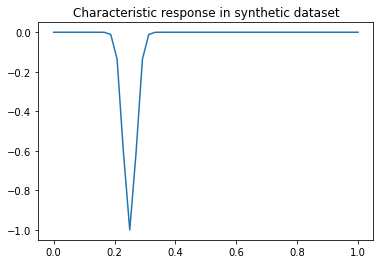

In [58]:
xs, ys = simple_gaussian(params.b, params.a, dataset.sample_rate)
ys = coef_mean[-1] * ys
plt.plot(xs, ys)

plt.title("Characteristic response in synthetic dataset")

### Visualize epoched data

In [59]:
# Epoch data.
epoch_tmin, epoch_tmax = torch.tensor(epoch_window)
epoch_samples = time_to_sample(epoch_tmax - epoch_tmin, dataset.sample_rate)
Y_epoch = torch.zeros((dataset.X_variable.shape[0], epoch_samples, dataset.Y.shape[-1]))
for i, word_onset in enumerate(dataset.word_onsets):
    word_onset_sample = time_to_sample(word_onset, dataset.sample_rate)
    word_offset_sample = word_onset_sample + epoch_samples
    Y_epoch[i, :, :] = dataset.Y[word_onset_sample:word_offset_sample, :]

Text(0.5, 0, 'Epoch time')

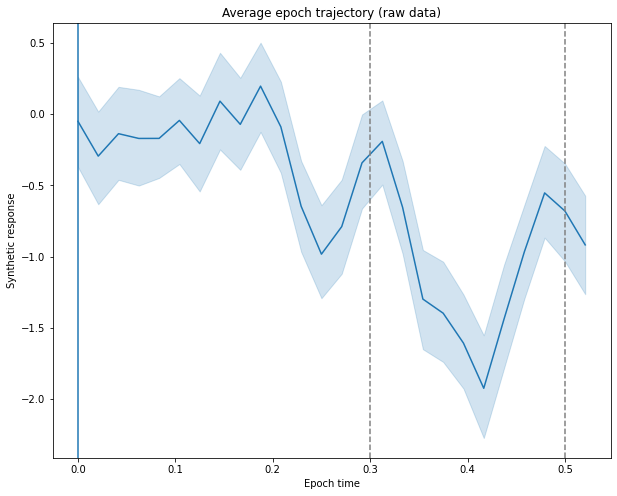

In [60]:
to_plot = pd.DataFrame(Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_variable[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value")
plt.axvline(0.0)
plt.axvline(0.3, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")

plt.title("Average epoch trajectory (raw data)")
plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

Text(0.5, 0, 'Epoch time')

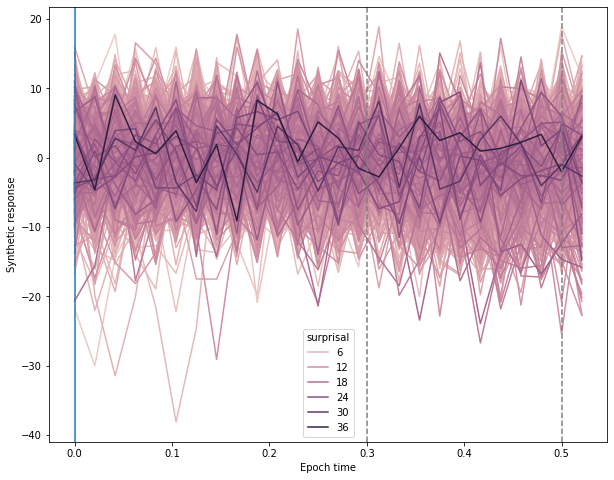

In [61]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)
plt.axvline(0.3, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")

plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

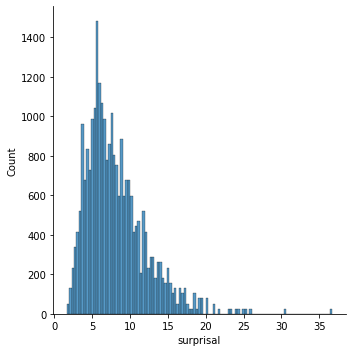

In [62]:
sns.displot(to_plot.surprisal)

## MLE regression

Raw visualization above doesn't produce a very clean EEG response. Let's try estimating a TRF model on the full data and see if we can recover something.

In [87]:
from sklearn.model_selection import ShuffleSplit

n_splits = 10
tmin, tmax = epoch_window
n_features = dataset.X_variable.shape[1] + dataset.X_ts.shape[1]
n_outputs = 1
encoder = TemporalReceptiveField(tmin, tmax, dataset.sample_rate,
                                 n_outputs=n_outputs,
                                 alpha=0)
coefs = torch.zeros((n_splits, n_features, len(encoder.delays_), n_outputs))

X_scatter = scatter_response_model(
    dataset.X_variable,
    dataset.X_ts,
    torch.zeros(dataset.X_variable.shape[0]).long(),
    dataset.phoneme_onsets_global,
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])
X_del, _ = TRFDelayer(tmin, tmax, dataset.sample_rate).transform(X_scatter)

idxs = torch.arange(X_scatter.shape[0])

split_size = X_del.shape[0] // n_splits
split_offsets = torch.arange(n_splits) * split_size
for i_split, offset in enumerate(tqdm(split_offsets)):
    idxs_i = idxs[offset:offset + split_size]
    X_i = X_del[idxs_i]
    X_i[:, 0] += torch.randn(X_i[:, 1].shape)
    encoder_i = encoder.fit(X_del[idxs_i], dataset.Y[idxs_i])
    coefs[i_split] = encoder_i.coef_

  0%|          | 0/10 [00:00<?, ?it/s]

In [90]:
coef_df = pd.DataFrame(coefs[:, 1, :, 0])
coef_df.index.name = "fold"
coef_df = coef_df.reset_index().melt(id_vars=["fold"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,fold,epoch_sample,value,epoch_time
0,0,0,0.000000,0.0
1,1,0,0.000000,0.0
2,2,0,0.000000,0.0
3,3,0,-0.084711,0.0
4,4,0,0.000000,0.0
...,...,...,...,...
265,5,26,0.000000,0.541667
266,6,26,0.000000,0.541667
267,7,26,0.000000,0.541667
268,8,26,0.000000,0.541667


Text(0.5, 0, 'Epoch time')

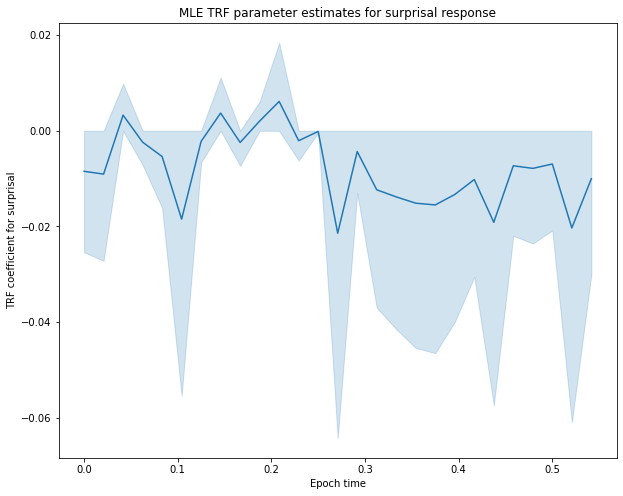

In [91]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value")

plt.title("MLE TRF parameter estimates for surprisal response")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

## Repro with new EM

In [92]:
from berp.datasets import NestedBerpDataset
from berp.models.trf_em import BerpTRFEM
from berp.solvers import AdamSolver
from optuna.distributions import UniformDistribution

In [268]:
# HACK
dataset.name = f"DKZ_1/{dataset.name}"
import importlib
import berp.models.trf_em
importlib.reload(berp.models.trf_em)

<module 'berp.models.trf_em' from '/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/models/trf_em.py'>

In [281]:
em = BerpTRFEM(berp.models.trf.TemporalReceptiveField(tmin, tmax, dataset.sample_rate, dataset.n_sensors,
                                      optim=AdamSolver(early_stopping=False), alpha=1e-2),
               n_iter=1,
               latent_params={"threshold": {0: UniformDistribution(0., 1.)}},
               n_outputs=dataset.n_sensors, n_phonemes=len(dataset.phonemes))

{'n_iter': 1}


In [270]:
TWO_PARAMS = em.pipeline.params[:2]
[p.threshold for p in TWO_PARAMS]

[tensor([0.2418]), tensor([0.1591])]

In [282]:
# HACK
em.pipeline.params = TWO_PARAMS
em.pipeline.param_weights = torch.ones(len(TWO_PARAMS)).float() / len(TWO_PARAMS)
em.param_resp_ = em.pipeline.param_weights[:]

In [283]:
nested = NestedBerpDataset([dataset])

In [284]:
resps = []
for _ in range(5):
    em.partial_fit(nested)
    resps.append(em.param_resp_)
    
torch.stack(resps)

INFO:berp.models.trf_em:Priming pipeline for subject DKZ_1
INFO:berp.models.trf_em:Priming pipeline for dataset DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/DKZ_1/c6db2cd7152348189ac763349b729388
INFO:berp.models.trf_em:E-step finished


wwww tensor([0.5000, 0.5000])
> /net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/models/trf.py(178)partial_fit()
    176         # TODO don't need to call this every iteration..
    177         import pdb; pdb.set_trace()
--> 178         np.save("X.npy", X.numpy())
    179         raise ValueError()
    180 



ipdb>  c


ValueError: 

In [99]:
em.pipeline.params[0].threshold

tensor([0.4942])

In [100]:
coef_df2 = pd.DataFrame(next(iter(em.pipeline.pipelines_.values())).encoder.coef_.unsqueeze(0)[:, 1, :, 0])
coef_df2.index.name = "iter"
coef_df2 = coef_df2.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df2["epoch_time"] = coef_df2.epoch_sample / dataset.sample_rate
coef_df2

,iter,epoch_sample,value,epoch_time
0,0,0,0.026981,0.0
1,0,1,0.034158,0.020833
2,0,2,0.002770,0.041667
3,0,3,0.051203,0.0625
4,0,4,0.000929,0.083333
5,0,5,-0.005396,0.104167
6,0,6,0.009529,0.125
7,0,7,0.052400,0.145833
8,0,8,0.028710,0.166667
9,0,9,0.059787,0.1875


Text(0.5, 0, 'Epoch time')

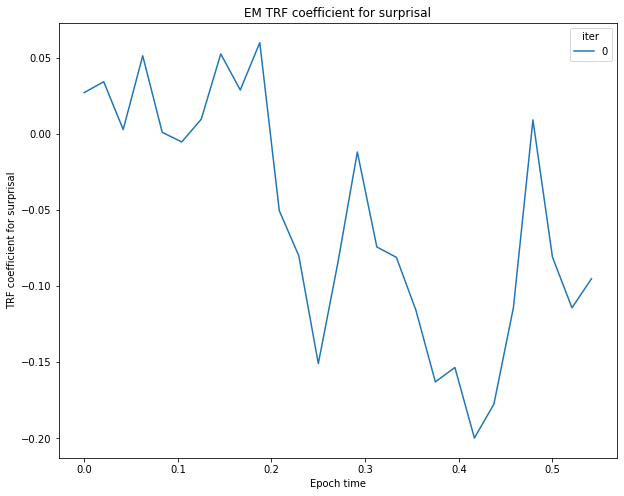

In [101]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df2, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

In [102]:
em.param_resp_

tensor([1.])

In [103]:
sum([weight * params.threshold for weight, params in zip(em.pipeline.param_weights, em.pipeline.params)])

tensor([0.4942])

In [104]:
em.get_params()

{'early_stopping': 1,
 'n_iter': 1,
 'pipeline__encoder__alpha': 0.01,
 'pipeline__encoder__fit_intercept': False,
 'pipeline__encoder__n_outputs': 1,
 'pipeline__encoder__optim__batch_size': 512,
 'pipeline__encoder__optim__early_stopping': False,
 'pipeline__encoder__optim__learning_rate': 0.01,
 'pipeline__encoder__optim__n_epochs': 1,
 'pipeline__encoder__optim__pbar': False,
 'pipeline__encoder__optim__random_state': None,
 'pipeline__encoder__optim': AdamSolver(early_stopping=False),
 'pipeline__encoder__sfreq': 48,
 'pipeline__encoder__tmax': 0.55,
 'pipeline__encoder__tmin': 0.0,
 'pipeline__encoder__warm_start': True,
 'pipeline__encoder': TemporalReceptiveField(alpha=0.01, n_outputs=1,
                        optim=AdamSolver(early_stopping=False), sfreq=48,
                        tmax=0.55, tmin=0.0),
 'pipeline__param_weights': tensor([1.]),
 'pipeline__params': [ModelParameters(lambda_=tensor(1.), confusion=tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## EM regression with latent recognition

In [290]:
import importlib
import berp.models.trf
importlib.reload(berp.models.trf)
importlib.reload(rr_em)

<module 'rr_em' from '/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/scripts/rr_em.py'>

In [291]:
# param_grid = [rr_em.get_parameters() for _ in range(50)]
# HACK pull from later pipeline to try to reproduce
param_grid = TWO_PARAMS

In [292]:
# SINGLE_PARAM

In [293]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=5, trf_alpha=1e-2,
                                 epoch_window=(tmin, tmax), solver="sgd",
                                 early_stopping_patience=3)

{'alpha': 0.01, 'fit_intercept': False, 'n_outputs': 1, 'optim__batch_size': 512, 'optim__early_stopping': None, 'optim__learning_rate': 0.01, 'optim__n_epochs': 1, 'optim__pbar': False, 'optim__random_state': None, 'optim': AdamSolver(early_stopping=None), 'sfreq': 48, 'tmax': 0.55, 'tmin': 0.0, 'warm_start': True}
{'sfreq': 48, 'tmax': 0.55, 'tmin': 0.0}


  0%|          | 0/5 [00:00<?, ?it/s]

wwww tensor([0.5000, 0.5000])
> /net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/models/trf.py(178)partial_fit()
    176         # TODO don't need to call this every iteration..
    177         import pdb; pdb.set_trace()
--> 178         np.save("X.npy", X.numpy())
    179         raise ValueError()
    180 



ipdb>  c


ValueError: 

In [148]:
weights

tensor([[1.0000, 0.0000],
        [0.4727, 0.5273],
        [0.4688, 0.5312],
        [0.4688, 0.5312]])

In [294]:
X_old = np.load("X.old.npy")
X_new = np.load("X.new.npy")
np.where(X_old != X_new)

(array([], dtype=int64), array([], dtype=int64))

In [279]:
X_old[3992]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [280]:
X_new[3992]

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 1.4180626, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
      dtype=float32)

In [109]:
coef_df = pd.DataFrame(torch.stack(encoders[1:])[:, 1, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,-0.001268,0.0
1,1,0,0.026975,0.0
2,2,0,0.026981,0.0
3,3,0,0.026981,0.0
4,0,1,0.021968,0.020833
...,...,...,...,...
103,3,25,-0.114285,0.520833
104,0,26,-0.076019,0.541667
105,1,26,-0.095225,0.541667
106,2,26,-0.095229,0.541667


Text(0.5, 0, 'Epoch time')

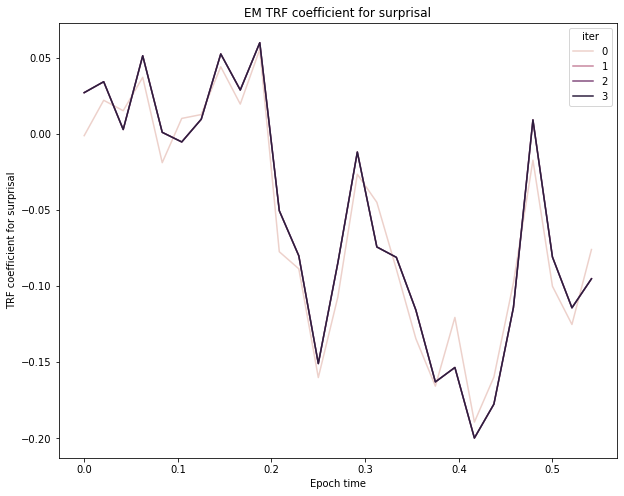

In [110]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

Text(0.5, 1.0, 'Distribution over weight grid, averaged over iterations')

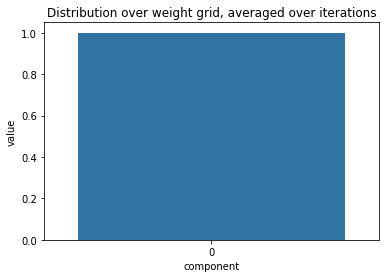

In [111]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

plt.title("Distribution over weight grid, averaged over iterations")

In [112]:
weights.numpy().round(3)

array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [113]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [114]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0    [0.49418253]
1    [0.49418253]
2    [0.49418253]
3    [0.49418253]
dtype: object

/home/jgauthie/om2/miniconda/envs/berp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jgauthie/om2/miniconda/envs/berp/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

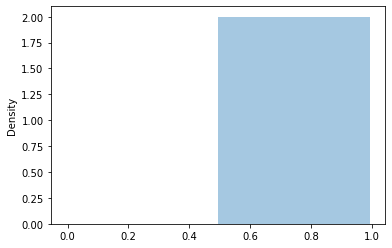

In [115]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [116]:
params.threshold

tensor(0.3252)

In [117]:
coef_df[coef_df.iter == 0]

,iter,epoch_sample,value,epoch_time
0,0,0,-0.001268,0.0
4,0,1,0.021968,0.020833
8,0,2,0.015119,0.041667
12,0,3,0.037058,0.0625
16,0,4,-0.018999,0.083333
20,0,5,0.010060,0.104167
24,0,6,0.012600,0.125
28,0,7,0.043960,0.145833
32,0,8,0.019473,0.166667
36,0,9,0.055399,0.1875


In [118]:
coef_df2

,iter,epoch_sample,value,epoch_time
0,0,0,0.026981,0.0
1,0,1,0.034158,0.020833
2,0,2,0.002770,0.041667
3,0,3,0.051203,0.0625
4,0,4,0.000929,0.083333
5,0,5,-0.005396,0.104167
6,0,6,0.009529,0.125
7,0,7,0.052400,0.145833
8,0,8,0.028710,0.166667
9,0,9,0.059787,0.1875
